<a href="https://colab.research.google.com/github/asmaa-kashef/APP/blob/master/1_NMT_Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Gathering and Processing 

To build a Machine Translation system, you need bilingual data, i.e. source sentences and their translations. You can use public bilingual corpora/datasets or you can use your translation memories (TMs). However, NMT requires a lot of data to train a good model, that is why most companies start with training a strong baseline model using public bilingual datasets, and then fine-tune this baseline model on their TMs. Sometimes also you can use pre-trained models directly for fine-tuning.

The majority of public bilingual datasets are collected on OPUS: https://opus.nlpl.eu/

Most of the datasets can be used for both commercial and non-commercial uses; however, some of them have more restricted licences. So you have to double-check the licence of a dataset before using it.

On OPUS, go to “Search & download resources” and choose two languages from the drop-down lists. You will see how it will list the available language datasets for this language pair. Try to use non-variant language codes like “en” for English and “fr” for French to get all the variants under this language. To know more details about a specific dataset, click its name.

In Machine Translation, we use the “Moses” format. Go ahead and try to download the “tico-19 v2020-10-28” by clicking “moses”. This will download a *.zip file; when you extract it, the two files that you care about are those whose names ending by the language codes. For example, for English to French, you will have “tico-19.en-fr.en” and “tico-19.en-fr.fr“. You can open these files with any text editor. Each file has a sentence/segment per line, and it is matching translation in the same line in the other file. This is what the "Moses" file format means.

Note that not all datasets are of the same quality. Some datasets have lower quality, especially big corpora crawled from the web. Check the provided “sample” before using the dataset. Nevertheless, even high-quality datasets, like those from the UN and EU, require filtering.



In [6]:
# Create a directory and clone the Github MT-Preparation repository
!mkdir nmt
%cd nmt
!git clone https://github.com/ymoslem/MT-Preparation.git

/content/nmt/nmt
Cloning into 'MT-Preparation'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 164 (delta 90), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (164/164), 39.11 KiB | 5.59 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [7]:
# Install the requirements
!pip3 install -r MT-Preparation/requirements.txt

# Datasets

Example datasets:

* EN-AR: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/ar-en.txt.zip
* EN-ES: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-es.txt.zip
* EN-FR: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-fr.txt.zip
* EN-RU: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-ru.txt.zip
* EN-ZH: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-zh.txt.zip

In [10]:
# Download and unzip a dataset
!wget https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/ar-en.txt.zip
!unzip ar-en.txt.zip

--2022-01-02 09:29:35--  https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/ar-en.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10584906 (10M) [application/zip]
Saving to: ‘ar-en.txt.zip.2’

ar-en.txt.zip.2     100%[===================>]  10.09M  8.27MB/s    in 1.2s    

2022-01-02 09:29:37 (8.27 MB/s) - ‘ar-en.txt.zip.2’ saved [10584906/10584906]

Archive:  ar-en.txt.zip
  inflating: UN.ar-en.ar             
  inflating: UN.ar-en.en             
  inflating: README                  


# Data Filtering

Filtering out low-quality segments can help improve the translation quality of the output MT model. This might include misalignments, empty segments, duplicates, among other issues. 

In [11]:
# Filter the dataset
# Arguments: source file, target file, source language, target language
!python3 MT-Preparation/filtering/filter.py UN.ar-en.en UN.ar-en.ar ar en

Dataframe shape (rows, columns): (74067, 2)
--- Rows with Empty Cells Deleted	--> Rows: 74067
--- Duplicates Deleted			--> Rows: 63852
--- Source-Copied Rows Deleted		--> Rows: 63848
--- Too Long Source/Target Deleted	--> Rows: 63074
--- HTML Removed			--> Rows: 63074
--- Rows will remain in true-cased	--> Rows: 63074
--- Rows with Empty Cells Deleted	--> Rows: 63074
--- Rows Shuffled			--> Rows: 63074
--- Source Saved: UN.ar-en.en-filtered.ar
--- Target Saved: UN.ar-en.ar-filtered.en


# Tokenization / Sub-wording

To build a vocabulary for any NLP model, you have to tokenize (i.e. split) sentences into smaller units. Word-based tokenization used to be the way to go; in this case, each word would be a token. However, an MT model can only learn a specific number of vocabulary tokens due to limited hardware resources. To solve this issue, sub-words are used instead of whole words. At the translation time, when the model sees a new word/token that looks like a word/token it has in the vocabulary, it still can try to continue the translation instead of marking this word as “unknown” or “unk”.

There are a few approaches to sub-wording such as BPE and the unigram model. One of the famous toolkits that incorporates the most common approaches is [SentencePiece](https://github.com/google/sentencepiece). Note that you have to train a sub-wording model and then use it. After translation, you will have to “desubword” or “decode” your text back using the same SentencePiece model.



In [12]:
!ls MT-Preparation/subwording/

1-train_bpe.py	1-train_unigram.py  2-subword.py  3-desubword.py


In [13]:
# Train a SentencePiece model for subword tokenization
!python MT-Preparation/subwording/1-train_unigram.py UN.ar-en.en-filtered.ar UN.ar-en.ar-filtered.en

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=UN.ar-en.en-filtered.ar --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --split_digits=true
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: UN.ar-en.en-filtered.ar
  input_format: 
  model_prefix: source
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_

In [14]:
!ls

ar-en.txt.zip	 README        target.vocab		UN.ar-en.en-filtered.ar
ar-en.txt.zip.1  source.model  UN.ar-en.ar
ar-en.txt.zip.2  source.vocab  UN.ar-en.ar-filtered.en
MT-Preparation	 target.model  UN.ar-en.en


In [15]:
# Subword the dataset
!python3 MT-Preparation/subwording/2-subword.py source.model target.model UN.ar-en.en-filtered.ar UN.ar-en.ar-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: UN.ar-en.en-filtered.ar
Target Dataset: UN.ar-en.ar-filtered.en
Done subwording the source file! Output: UN.ar-en.en-filtered.ar.subword
Done subwording the target file! Output: UN.ar-en.ar-filtered.en.subword


In [16]:
!ls

ar-en.txt.zip	 source.model  UN.ar-en.ar-filtered.en
ar-en.txt.zip.1  source.vocab  UN.ar-en.ar-filtered.en.subword
ar-en.txt.zip.2  target.model  UN.ar-en.en
MT-Preparation	 target.vocab  UN.ar-en.en-filtered.ar
README		 UN.ar-en.ar   UN.ar-en.en-filtered.ar.subword


In [18]:
# First 3 lines before subwording
!head -n 3 UN.ar-en.ar-filtered.en && echo "-----" && head -n 3 UN.ar-en.ar-filtered.en

30 - تهيب بالدول وبالمنظمات الإقليمية ذات الصلة المعنية بإدارة مصائد الأسماك أن تتخذ، على سبيل الأولوية، تدابير فعالة لتحسين إدارة قدرات الصيد وأن تطبق، بحلول عام 2005، خطة العمل الدولية لإدارة قدرات الصيد، مع القيام، عن طريق هذه الإجراءات، بمراعاة ضرورة تجنب نقل قدرات الصيد إلى مصائد أخرى أو مناطق أخرى بما فيها، على سبيل الذكر لا الحصر، المناطق التي أصبح فيها استغلال مصائد الأسماك مفرطا أو نضبت فيها تلك المصائد؛
3 - تحيط علما مع التقدير بالاحتفال بيوم 23 حزيران/يونيه بوصفه يوم الأمم المتحدة للخدمة العامة وبمنح جائزة الأمم المتحدة للخدمة العامة، مما يبعث في موظفي الخدمة العامة في كل أنحاء العالم الدافع لتعزيز الإدارة العامة بوصفها أداة للتنمية، وفي هذا الصدد تشجع الدول الأعضاء على المشاركة في عملية الجوائز من خلال تقديم المرشحين؛
(هـ) التدمير المتعمد لأنشطة إدامة الحياة؛
-----
30 - تهيب بالدول وبالمنظمات الإقليمية ذات الصلة المعنية بإدارة مصائد الأسماك أن تتخذ، على سبيل الأولوية، تدابير فعالة لتحسين إدارة قدرات الصيد وأن تطبق، بحلول عام 2005، خطة العمل الدولية لإدارة قدرات الصيد، مع ال

In [19]:
!ls

ar-en.txt.zip	 source.model  UN.ar-en.ar-filtered.en
ar-en.txt.zip.1  source.vocab  UN.ar-en.ar-filtered.en.subword
ar-en.txt.zip.2  target.model  UN.ar-en.en
MT-Preparation	 target.vocab  UN.ar-en.en-filtered.ar
README		 UN.ar-en.ar   UN.ar-en.en-filtered.ar.subword


In [20]:
!ls

ar-en.txt.zip	 source.model  UN.ar-en.ar-filtered.en
ar-en.txt.zip.1  source.vocab  UN.ar-en.ar-filtered.en.subword
ar-en.txt.zip.2  target.model  UN.ar-en.en
MT-Preparation	 target.vocab  UN.ar-en.en-filtered.ar
README		 UN.ar-en.ar   UN.ar-en.en-filtered.ar.subword


In [21]:
# First 3 lines after subwording
!head -n 3 UN.ar-en.en-filtered.ar.subword && echo "---" && head -n 3 UN.ar-en.ar-filtered.en.subword

▁ 3 0 . ▁Calls ▁upon ▁States ▁and ▁relevant ▁regional ▁fisheries ▁management ▁organizations , ▁as ▁a ▁matter ▁of ▁priority , ▁to ▁take ▁effective ▁measures ▁to ▁improve ▁the ▁management ▁of ▁fishing ▁capacity ▁and ▁to ▁put ▁into ▁effect ▁by ▁ 2 0 0 5 ▁the ▁International ▁Plan ▁of ▁Action ▁for ▁the ▁Management ▁of ▁Fishing ▁Capacity , ▁taking ▁into ▁account ▁the ▁need , ▁through ▁the se ▁actions , ▁to ▁avoid ▁the ▁transfer ▁of ▁fishing ▁capacity ▁to ▁other ▁fisheries ▁or ▁areas ▁including , ▁ but ▁not ▁limited ▁to , ▁th ose ▁areas ▁where ▁fisheries ▁are ▁overexploit ed ▁or ▁in ▁a ▁deplet ed ▁condition ;
▁ 3 . ▁Take s ▁note ▁with ▁appreciation ▁of ▁the ▁commemoration ▁of ▁ 2 3 ▁June ▁as ▁Unit ed ▁Nations ▁Public ▁Service ▁Day ▁and ▁the ▁grant ing ▁of ▁the ▁Unit ed ▁Nations ▁Public ▁Service ▁Awards , ▁which ▁provide ▁motivation ▁for ▁public ▁servants ▁all ▁over ▁the ▁world ▁to ▁enhance ▁public ▁administration ▁as ▁a ▁tool ▁for ▁development , ▁and ▁in ▁this ▁regard ▁encourages ▁Member ▁Sta

# Data Splitting

We usually split our dataset into 3 portions:

1. training dataset - used for training the model;
2. development dataset - used to run regular validations during the training to help improve the model parameters; and
3. testing dataset - a holdout dataset used after the model finishes training to finally evaluate the model on unseen data.

In [22]:
# Split the dataset into training set, development set, and test set
# Development and test sets should be between 1000 and 5000 segments (here we chose 2000)
!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 UN.ar-en.ar-filtered.en.subword UN.ar-en.en-filtered.ar.subword

Dataframe shape: (63074, 2)
--- Empty Cells Deleted --> Rows: 63074
--- Wrote Files
Done!
Output files
UN.ar-en.ar-filtered.en.subword.train
UN.ar-en.en-filtered.ar.subword.train
UN.ar-en.ar-filtered.en.subword.dev
UN.ar-en.en-filtered.ar.subword.dev
UN.ar-en.ar-filtered.en.subword.test
UN.ar-en.en-filtered.ar.subword.test


In [23]:
# Line count for the subworded train, dev, test datatest
!wc -l *.subword.*

    2000 UN.ar-en.ar-filtered.en.subword.dev
    2000 UN.ar-en.ar-filtered.en.subword.test
   59074 UN.ar-en.ar-filtered.en.subword.train
    2000 UN.ar-en.en-filtered.ar.subword.dev
    2000 UN.ar-en.en-filtered.ar.subword.test
   59074 UN.ar-en.en-filtered.ar.subword.train
  126148 total


In [24]:
# Check the first and last line from each dataset

# -------------------------------------------
# Change this cell to print your name
!echo -e "My name is: FirstName SecondName \n"
# -------------------------------------------

!echo "---First line---"
!head -n 1 *.{train,dev,test}

!echo -e "\n---Last line---"
!tail -n 1 *.{train,dev,test}

My name is: FirstName SecondName 

---First line---
==> UN.ar-en.ar-filtered.en.subword.train <==
▁ 3 0 ▁- ▁تهيب ▁بالدول ▁وب المنظمات ▁الإقليمية ▁ذات ▁الصلة ▁المعنية ▁ب إدارة ▁مصائد ▁الأسماك ▁أن ▁تتخذ ، ▁على ▁سبيل ▁الأولوية ، ▁تدابير ▁فعالة ▁ لتحسين ▁ إدارة ▁قدرات ▁الصيد ▁وأن ▁تطبق ، ▁بحلول ▁عام ▁ 2 0 0 5 ، ▁ خطة ▁العمل ▁الدولية ▁ لإدارة ▁قدرات ▁الصيد ، ▁مع ▁القيام ، ▁عن ▁طريق ▁هذه ▁الإجراءات ، ▁ب مراعاة ▁ضرورة ▁تجنب ▁نقل ▁قدرات ▁الصيد ▁إلى ▁مصائد ▁أخرى ▁أو ▁مناطق ▁أخرى ▁بما ▁فيها ، ▁على ▁سبيل ▁الذكر ▁لا ▁الحصر ، ▁المناطق ▁التي ▁أصبح ▁فيها ▁استغلال ▁مصائد ▁الأسماك ▁مفرط ا ▁أو ▁نض بت ▁فيها ▁تلك ▁المصائد ؛

==> UN.ar-en.en-filtered.ar.subword.train <==
▁ 3 0 . ▁Calls ▁upon ▁States ▁and ▁relevant ▁regional ▁fisheries ▁management ▁organizations , ▁as ▁a ▁matter ▁of ▁priority , ▁to ▁take ▁effective ▁measures ▁to ▁improve ▁the ▁management ▁of ▁fishing ▁capacity ▁and ▁to ▁put ▁into ▁effect ▁by ▁ 2 0 0 5 ▁the ▁International ▁Plan ▁of ▁Action ▁for ▁the ▁Management ▁of ▁Fishing ▁Capacity , ▁taki

# Mount your drive to save your data

Click the folder icon to the left, and then click the Google Drive icon.

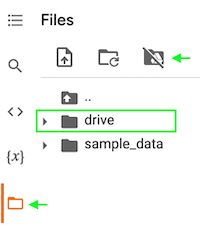

In [25]:
# Move your data to your Google Drive
%cd ..
!mv nmt drive/MyDrive/

/content/nmt
mv: cannot move 'nmt' to 'drive/MyDrive/': No such file or directory


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Open the folder where you saved your prepapred datasets from the first exercise
%cd drive/MyDrive/nmt/
!ls

/content/drive/MyDrive/nmt
config.yaml  nmt


In [31]:
%cd ..
!mv nmt drive/MyDrive/

/content
mv: inter-device move failed: 'nmt' to 'drive/MyDrive/nmt'; unable to remove target: Directory not empty


In [ ]:
# Create the YAML configuration file
# On a regular machine, you can create it manually or with nano
# Note here we are using some smaller values because the dataset is small
# For larger datasets, consider increasing: train_steps, valid_steps, warmup_steps, save_checkpoint_steps, keep_checkpoint

config = '''# config.yaml


## Where the samples will be written
save_data: run

# Training files
data:
    corpus_1:
        path_src:UN.ar-en.ar-filtered.en.subword.train
        path_tgt:UN.ar-en.en-filtered.ar.subword.train
        transforms: [filtertoolong]
    valid:
        path_src: UN.ar-en.en-filtered.ar.subword.dev
        path_tgt: UN.en-fr.en-filtered.en.subword.dev
        transforms: [filtertoolong]

# Vocabulary files, generated by onmt_build_vocab
src_vocab: run/source.vocab
tgt_vocab: run/target.vocab

# Vocabulary size - should be the same as in sentence piece
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filter out source/target longer than n if [filtertoolong] enabled
#src_seq_length: 200
#src_seq_length: 200

# Tokenization options
src_subword_model: source.model
tgt_subword_model: target.model

# Where to save the log file and the output models/checkpoints
log_file: train.log
save_model: models/model.fren

# Stop training if it does not imporve after n validations
early_stopping: 4

# Default: 5000 - Save a model checkpoint for each n
save_checkpoint_steps: 1000

# To save space, limit checkpoints to last n
# keep_checkpoint: 3

seed: 3435

# Default: 100000 - Train the model to max n steps 
# Increase for large datasets
train_steps: 3000

# Default: 10000 - Run validation after n steps
valid_steps: 1000

# Default: 4000 - for large datasets, try up to 8000
warmup_steps: 1000
report_every: 100

decoder_type: transformer
encoder_type: transformer
word_vec_size: 512
rnn_size: 512
layers: 6
transformer_ff: 2048
heads: 8

accum_count: 4
optim: adam
adam_beta1: 0.9
adam_beta2: 0.998
decay_method: noam
learning_rate: 2.0
max_grad_norm: 0.0

# Tokens per batch, change if out of GPU memory
batch_size: 4096
valid_batch_size: 4096
batch_type: tokens
normalization: tokens
dropout: 0.1
label_smoothing: 0.1

max_generator_batches: 2

param_init: 0.0
param_init_glorot: 'true'
position_encoding: 'true'

# Number of GPUs, and IDs of GPUs
world_size: 1
gpu_ranks: [0]

'''

with open("config.yaml", "w+") as config_yaml:
  config_yaml.write(config)

In [ ]:
# Split the dataset into training set, development set, and test set
# Development and test sets should be between 1000 and 5000 segments (here we chose 2000)
!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 UN.ar-en.ar-filtered.en.subword UN.ar-en.en-filtered.ar.subword

Dataframe shape: (63074, 2)
--- Empty Cells Deleted --> Rows: 63074
--- Wrote Files
Done!
Output files
UN.ar-en.ar-filtered.en.subword.train
UN.ar-en.en-filtered.ar.subword.train
UN.ar-en.ar-filtered.en.subword.dev
UN.ar-en.en-filtered.ar.subword.dev
UN.ar-en.ar-filtered.en.subword.test
UN.ar-en.en-filtered.ar.subword.test
